In [57]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
from timeit import Timer
from os.path import exists
from collections import defaultdict
from IPython.core.display import display, HTML
import statistics
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import pyro
# import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_probability as tfp
# import tensorflow
# from tensorflow import float32
import torch
import copy
from tqdm import tqdm
from warnings import warn
from samplers import LangevinDynamics #notice in samplers, learning rate means step size
from samplers import MetropolisAdjustedLangevin
from precondSGLD import pSGLD
#import pyro
#from pyro.infer import MCMC, UncalibratedLangevin

# ULA and MALA

## Guassian Model

In [58]:
np.random.seed(19)
torch.manual_seed(19)

if not torch.cuda.is_available():
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.FloatTensor')
else:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

class GaussianDistribution(object):
    def __init__(self, mu, cov, device='cuda'):
        super(GaussianDistribution, self).__init__()

        self.mu = mu
        self.cov = cov
        self.precision = torch.inverse(cov)

        self.R = torch.linalg.cholesky(self.cov)
        self.normal = torch.distributions.normal.Normal(torch.zeros_like(mu),
            torch.ones_like(mu))

    def nl_pdf(self, x):
        return 0.5*(
            ((x - self.mu).T).matmul(self.precision)).matmul(x - self.mu)

    def sample(self):
        return self.R.matmul(self.normal.sample()) + self.mu


dim = 2

mu = torch.Tensor([1.2, .6], device=device)
cov = (
    0.9*(torch.ones([2, 2], device=device) -
         torch.eye(2, device=device)).T +
    torch.eye(2, device=device)*1.3
)
gaussian_dist = GaussianDistribution(mu, cov, device=device)

In [59]:
# tensorflow distrbution
tfd = tfp.distributions
m = mu.numpy()
sigma = cov.numpy()
gaussian = tfd.MultivariateNormalFullCovariance(
           loc=m,
           covariance_matrix=sigma)

In [60]:
# check eigenvalue of the covariance
np.linalg.eig(sigma)

(array([2.1999998 , 0.39999998], dtype=float32),
 array([[ 0.70710677, -0.70710677],
        [ 0.70710677,  0.70710677]], dtype=float32))

In the case of SGMCMC, we choose stepsize $h< 4\times 0.4 = 1.6$ to avoid divergence of the chain.

In [61]:
# np.random.seed(19)
# torch.manual_seed(19)

# if not torch.cuda.is_available():
#     device = torch.device('cpu')
#     torch.set_default_tensor_type('torch.FloatTensor')
# else:
#     device = torch.device('cuda')
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

# class GaussianDistribution(object):
#     def __init__(self, mu, cov, device='cuda'):
#         super(GaussianDistribution, self).__init__()

#         self.mu = mu
#         self.cov = cov
#         self.precision = np.linalg.inv(cov)

#         self.R = np.linalg.cholesky(self.cov)
#         self.normal = torch.distributions.normal.Normal(torch.zeros_like(mu),
#             torch.ones_like(mu))

#     def nl_pdf(self, x):
#         return 0.5*(
#             ((x - self.mu).T).matmul(self.precision)).matmul(x - self.mu)

#     def sample(self):
#         return self.R.matmul(self.normal.sample()) + self.mu


# dim = 2

# mu = torch.Tensor([1.2, .6], device=device)
# cov = (
#     0.9*(torch.ones([2, 2], device=device) -
#          torch.eye(2, device=device)).T +
#     torch.eye(2, device=device)*1.3
# )
# gaussian_dist = GaussianDistribution(mu, cov, device=device)

In [62]:
# tfd = tfp.distributions
# dtype = np.float32

# # Target distribution is Standard Univariate Normal
# target = tfd.Normal(loc=dtype(0), scale=dtype(1))

# def target_log_prob(x):
#     return target.log_prob(x)

# tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=target_log_prob,
#         step_size=0.75)
# def target_log_prob(x):
#     return tf.constant(np.log(gaussian_dist.nl_pdf(x)).numpy())
# def target_log_prob(x):
#     return np.log(0.5*(
#             np.matmul(
#                 np.matmul((x - m).T,np.linalg.inv(sigma))
#                 ,x - m)))
# samples = tfp.mcmc.sample_chain(
#     num_results=10,
#     current_state=tf.zeros(2),
#     kernel=tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=gaussian.log_prob,
#         step_size=0.75)
#     ,num_burnin_steps=500
#     ,trace_fn=None
# )
# samples = MCMC(
#     kernel=tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=target_log_prob,
#         step_size=0.75),
#     num_samples=max_itr
#     #current_state=tf.constant([2.0, 1.0]),
#     #num_burnin_steps=500,
#     #trace_fn=None
# )

In [63]:
from  scipy.stats import multivariate_normal

# contour plot
N = 300
X = np.linspace(-2, 7, N)
Y = np.linspace(-3, 6, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

In [64]:
est_samples = dict()
max_itr = int(1e3*2)
burn_in = 500

## ULA

In [66]:
# ULA
## Define ULA sampler with `step_size` equal to 0.75
samples_ula = tfp.mcmc.sample_chain(
    num_results=max_itr,
    current_state=tf.zeros(2),
    kernel=tfp.mcmc.UncalibratedLangevin(
        target_log_prob_fn=gaussian.log_prob,
        step_size=0.75)
    # ,num_steps_between_results=3
    ,num_burnin_steps=burn_in
    ,trace_fn=None
)

est_samples_ula = np.array(samples_ula)[200:]
loss_log_ula = np.apply_along_axis(gaussian.log_prob, 1, samples_ula.numpy())

num_samples_ula = est_samples_ula.shape[0]
true_samples_ula = np.zeros([num_samples_ula, len(mu)])
for j in range(num_samples_ula):
    true_samples_ula[j, :] = gaussian_dist.sample().cpu().numpy()


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:317: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [67]:
est_samples['ula'] = est_samples_ula

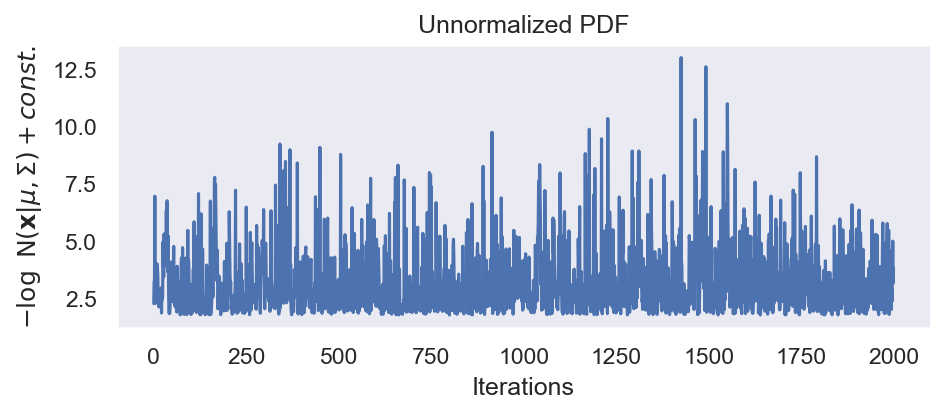

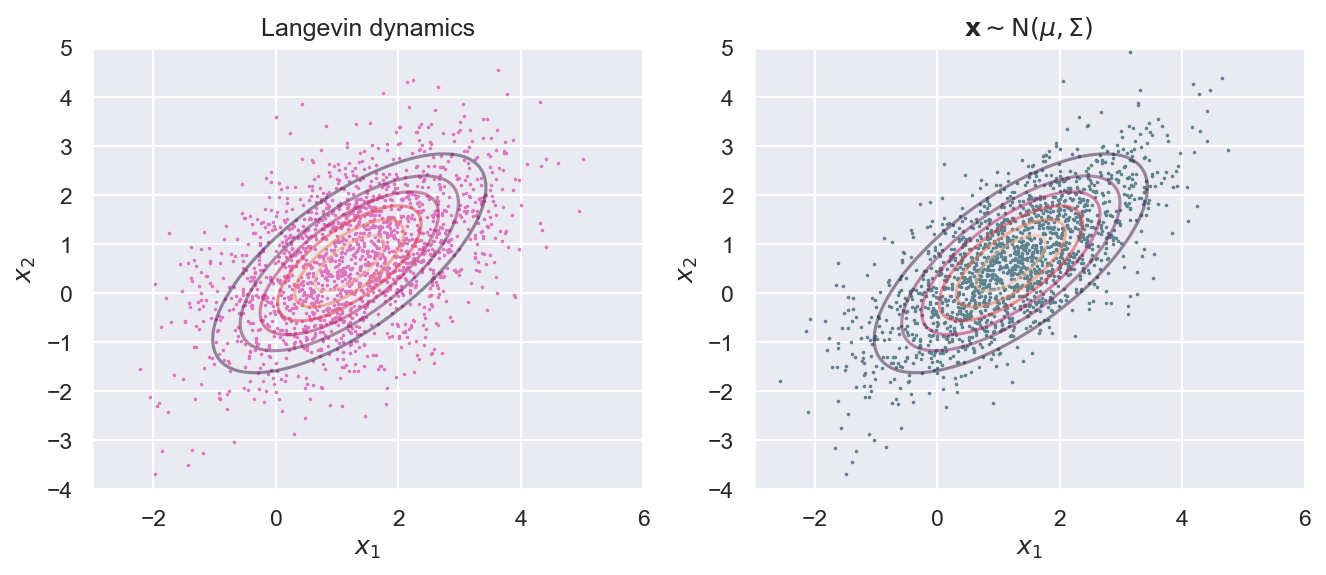

In [68]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(-loss_log_ula)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.contour(X, Y, Z, alpha=0.5)
plt.scatter(est_samples_ula[:, 0], est_samples_ula[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")
plt.subplot(122)
plt.contour(X, Y, Z, alpha=0.5)
p2 = plt.scatter(true_samples_ula[:, 0], true_samples_ula[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

## MALA

In [69]:
# MALA
## Define MALA sampler with `step_size` equal to 0.75
samples_mala = tfp.mcmc.sample_chain(
    num_results=max_itr,
    current_state=tf.zeros(2),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=gaussian.log_prob,
        step_size=0.75)
    ,num_burnin_steps=500
    ,trace_fn=None
)

est_samples_mala = np.array(samples_mala)[200:]
loss_log = np.apply_along_axis(gaussian.log_prob, 1, samples_mala.numpy())

num_samples_mala = est_samples_mala.shape[0]
true_samples_mala = np.zeros([num_samples_mala, 2])
for j in range(num_samples_mala):
    true_samples_mala[j, :] = gaussian_dist.sample().cpu().numpy()

In [70]:
est_samples['mala'] = est_samples_mala

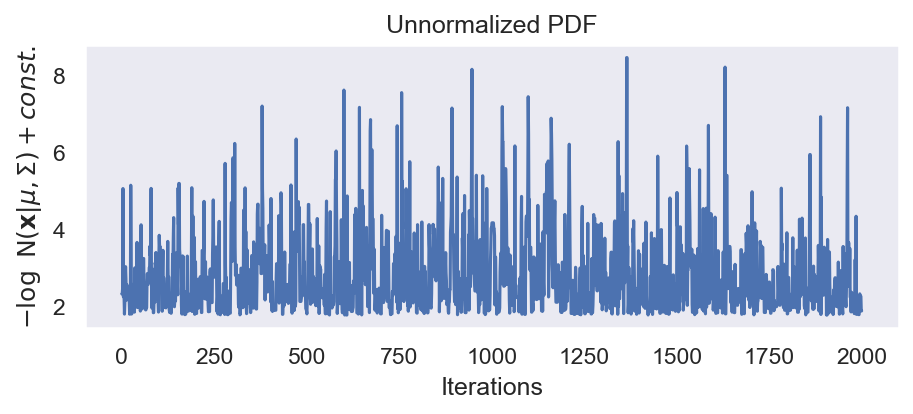

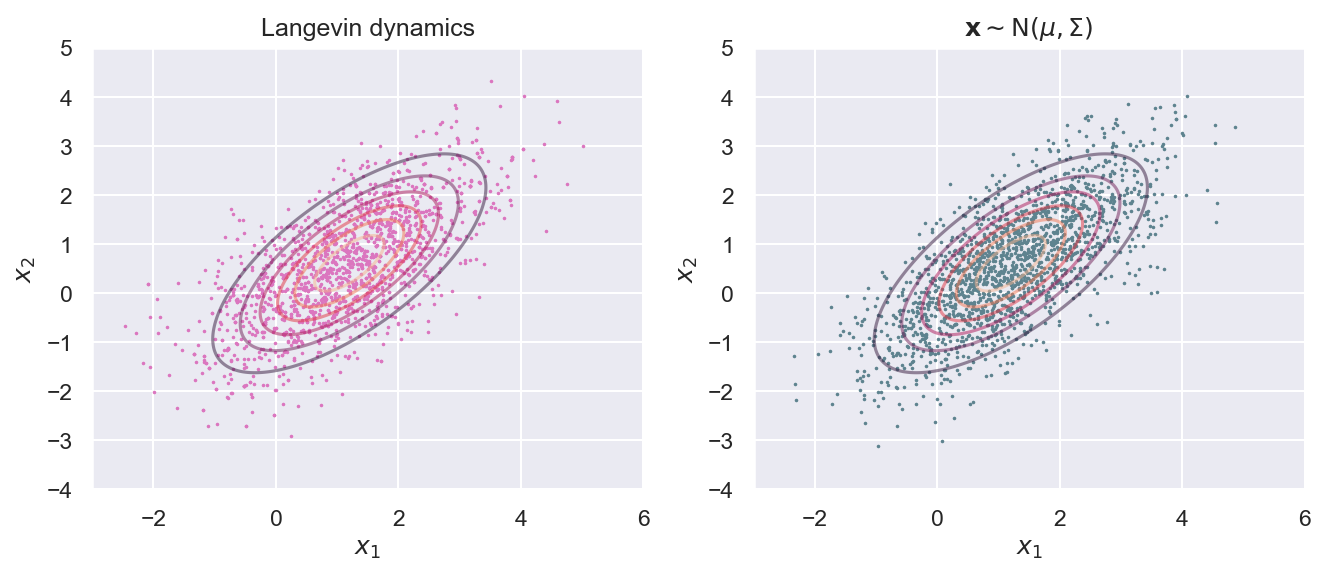

In [71]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(-loss_log)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.contour(X, Y, Z, alpha=0.5)
plt.scatter(est_samples_mala[:, 0], est_samples_mala[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")
plt.subplot(122)
plt.contour(X, Y, Z, alpha=0.5)
p2 = plt.scatter(true_samples_mala[:, 0], true_samples_mala[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

# Stochastic Gradient Version of ULA and MALA

## SG-ULA

In [72]:
x = torch.zeros([2], requires_grad=True, device=device)
langevin_dynamics = LangevinDynamics(
    x,
    gaussian_dist.nl_pdf,
    lr=0.2,
    # lr_final=4e-2,
    max_itr=max_itr+burn_in,
    device=device
)

hist_samples_sgula = []
loss_log_sgula = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample()
    loss_log_sgula.append(loss)
    # if j%3 == 0:
    # without thinning -- same setup as MCMC
    hist_samples_sgula.append(est.cpu().numpy())
est_samples_sgula = np.array(hist_samples_sgula[burn_in:])[200:]

num_samples_sgula = est_samples_sgula.shape[0]
true_samples_sgula = np.zeros([num_samples_sgula, 2])
for j in range(num_samples_sgula):
    true_samples_sgula[j, :] = gaussian_dist.sample().cpu().numpy()

100%|██████████| 2000/2000 [00:00<00:00, 12062.49it/s]


In [73]:
est_samples['sgula'] = est_samples_sgula

  0%|          | 1/9800 [08:00<1307:46:07, 480.45s/it]


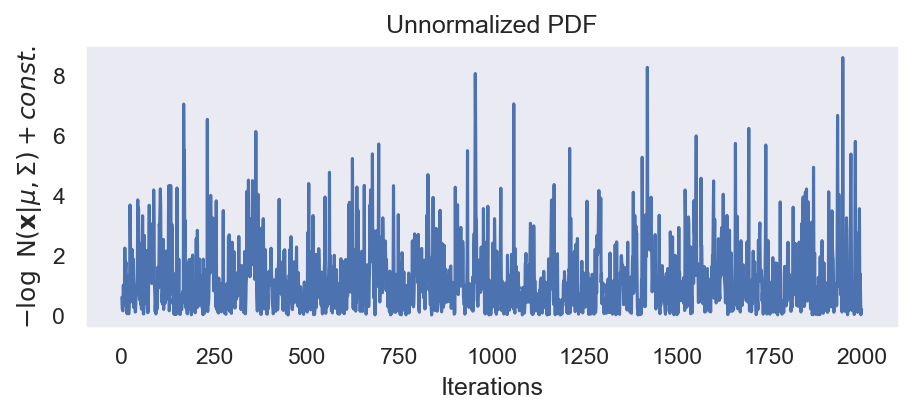

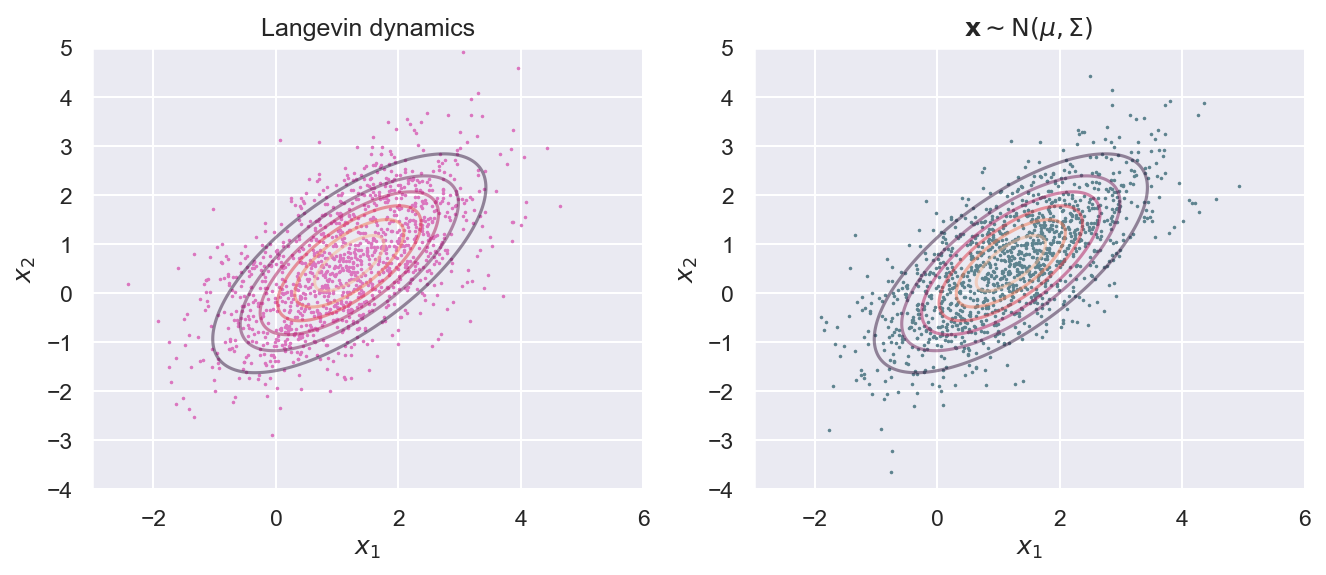

In [74]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log_sgula)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.contour(X, Y, Z, alpha=0.5)
plt.scatter(est_samples_sgula[:, 0], est_samples_sgula[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")

plt.subplot(122)
plt.contour(X, Y, Z, alpha=0.5)
p2 = plt.scatter(true_samples_sgula[:, 0], true_samples_sgula[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

SG-ULA actually gives good coverage of the density. This may due to the choice of learning rate (step size). Try with constant see the result.

When using fixed learning rate, 0.2 actually gives good result, balancing trade off of exploration and exploitation.

## SG-MALA

In [75]:
x = torch.zeros([2], requires_grad=True, device=device)

mala = MetropolisAdjustedLangevin(
    x,
    gaussian_dist.nl_pdf,
    lr=0.1,
    # lr_final=4e-2,
    max_itr=max_itr+burn_in,
    device=device
)

hist_samples_sgmala = []
loss_log_sgmala = []
for j in tqdm(range(max_itr)):
    est, loss = mala.sample()
    loss_log_sgmala.append(loss)
    # if j%3 == 0: 
    # if without thinning -- same setup as MCMC 
    hist_samples_sgmala.append(est.cpu().numpy())
est_samples_sgmala = np.array(hist_samples_sgmala[burn_in:])[200:]

num_samples_sgmala = est_samples_sgmala.shape[0]
true_samples_sgmala = np.zeros([num_samples_sgmala, 2])
for j in range(num_samples_sgmala):
    true_samples_sgmala[j, :] = gaussian_dist.sample().cpu().numpy()

100%|██████████| 2000/2000 [00:00<00:00, 5471.78it/s]


In [76]:
est_samples['sgmala'] = est_samples_sgmala

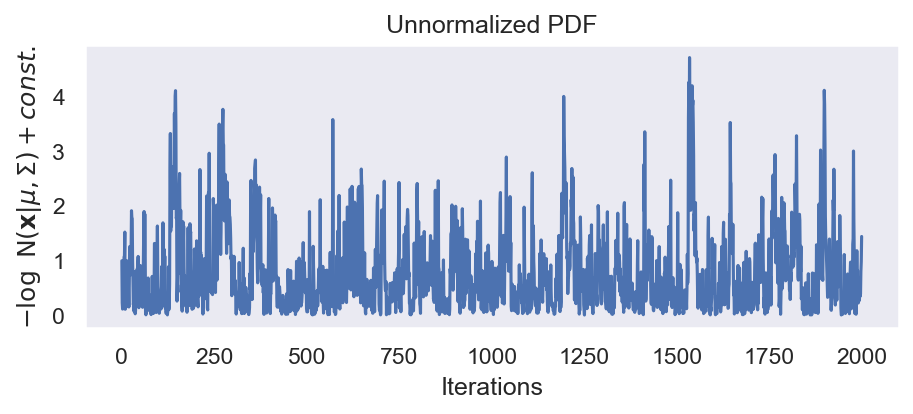

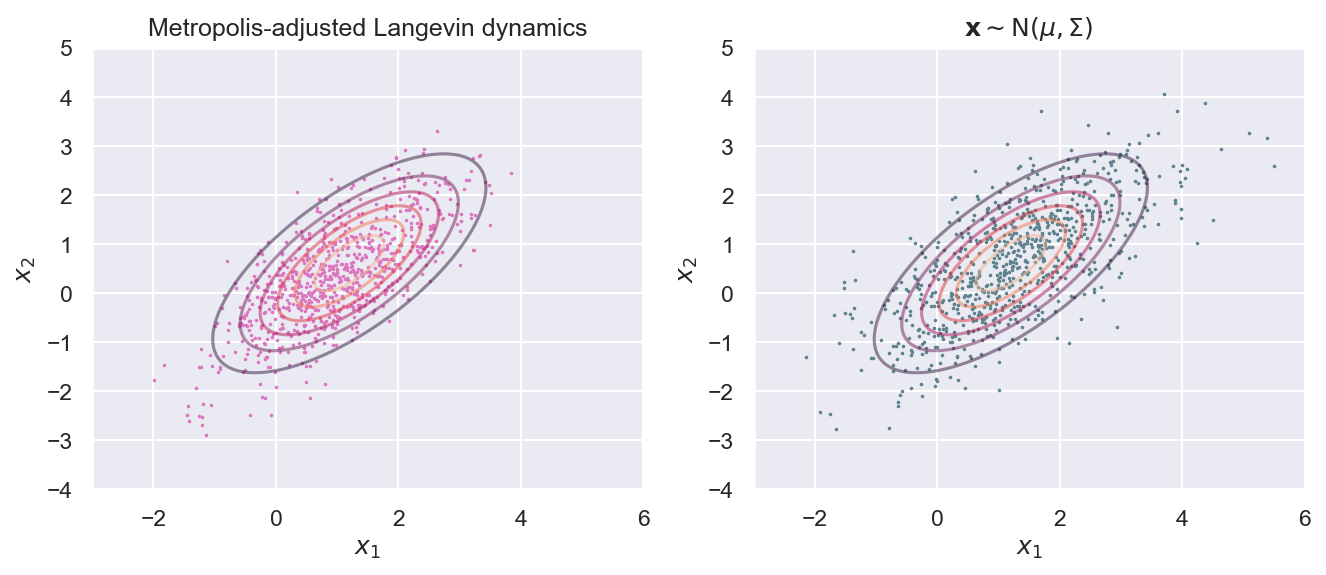

In [77]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log_sgmala)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.contour(X, Y, Z, alpha=0.5)
plt.scatter(est_samples_sgmala[500:, 0], est_samples_sgmala[500:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Metropolis-adjusted Langevin dynamics")

plt.subplot(122)
plt.contour(X, Y, Z, alpha=0.5)
p2 = plt.scatter(true_samples_sgmala[500:, 0], true_samples_sgmala[500:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

With the adaptive learning rate, the SG-MALA over-corrects for one direction and under-correct for the other. The fixed learning rate also works! And it is less sensitive to the choice of lr comparing to ULA. However, for lr~0.75, which works fine for MALA, results in higher rejection rate in the tail evident in the plot -- the number of samples from the tail is less than the oracle sampler.

# Kernel Stein Estimator

In [78]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [79]:
from ksd.discrepancies import KSD
from ksd.kernels import InverseMultiquadricKernel
from ksd.example_Gaussian import Gaussian

In [80]:
import torch
from torch.autograd import Variable, Function
from torch.autograd import grad

import autograd.numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [81]:
# p has known log-lik derivative
# q only has a set of samples
p = Gaussian(dict(mu=mu, sigma=sigma))
ksd_list = []

In [82]:
for sampler, q in est_samples.items():
    gaussian_ksd = KSD('imq', dict(c=1, beta=-0.5), p=p, q=q)
    ksd_list.append(gaussian_ksd.discrepancy())

  4%|▍         | 72/1800 [01:12<29:36,  1.03s/it]